In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pickle

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
!wget --no-check-certificate \
    https://drive.google.com/uc?id=13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P -O /tmp/sentiment.csv

--2021-05-21 08:03:23--  https://drive.google.com/uc?id=13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P
Resolving drive.google.com (drive.google.com)... 108.177.125.139, 108.177.125.138, 108.177.125.102, ...
Connecting to drive.google.com (drive.google.com)|108.177.125.139|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-08-ak-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/s5519h1lm57nqej791lheisbb27t45se/1621584150000/11118900490791463723/*/13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P [following]
--2021-05-21 08:03:24--  https://doc-08-ak-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/s5519h1lm57nqej791lheisbb27t45se/1621584150000/11118900490791463723/*/13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P
Resolving doc-08-ak-docs.googleusercontent.com (doc-08-ak-docs.googleusercontent.com)... 74.125.23.132, 2404:6800:4008:c03::84
Connecting to doc-08-ak-docs.googleusercontent.com (doc-08-ak-docs.googleusercontent.com)|74.

In [3]:
dataset = pd.read_csv('/tmp/sentiment.csv')
dataset.head()

,Unnamed: 0,text,sentiment
0,0,So there is no way for me to plug it in here i...,0
1,1,Good case Excellent value.,1
2,2,Great for the jawbone.,1
3,3,Tied to charger for conversations lasting more...,0
4,4,The mic is great.,1


In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1992 entries, 0 to 1991
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  1992 non-null   int64 
 1   text        1992 non-null   object
 2   sentiment   1992 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 46.8+ KB


In [6]:
dataset.isnull().sum()

Unnamed: 0    0
text          0
sentiment     0
dtype: int64

In [9]:
dataset['sentiment'].value_counts()

1    996
0    996
Name: sentiment, dtype: int64

In [7]:
# Extract out sentences and labels
sentences = dataset['text'].tolist()
labels = dataset['sentiment'].tolist()

In [8]:
# Print some example sentences and labels
for x in range(2):
  print(sentences[x])
  print(labels[x])
  print("\n")

So there is no way for me to plug it in here in the US unless I go by a converter.
0


Good case Excellent value.
1




In [10]:
# Separate out the sentences and labels into training and test sets
training_size = int(len(sentences) * 0.8)

training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

# Make labels into numpy arrays for use with the network later
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

In [11]:
vocab_size = 1000
embedding_dim = 16
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

# TRAINING

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, 
                       truncating=trunc_type)

# TESTING

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, 
                               padding=padding_type, truncating=trunc_type)

In [13]:
model_multiple_bidi_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim, 
                                                       return_sequences=True)), 
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_multiple_bidi_lstm.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [14]:
model_multiple_bidi_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 16)           16000     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 100, 32)           4224      
_________________________________________________________________
bidirectional_3 (Bidirection (None, 32)                6272      
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 198       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 7         
Total params: 26,701
Trainable params: 26,701
Non-trainable params: 0
_________________________________________________________________


In [16]:
num_epochs = 30
EARLY_STOP_PATIENCE = 3

early_stopper = EarlyStopping(monitor = 'val_loss', patience = EARLY_STOP_PATIENCE)
checkpointer = ModelCheckpoint(filepath = './best.h5', monitor = 'val_loss', save_best_only = True, mode = 'auto')


In [19]:
history = model_multiple_bidi_lstm.fit(padded, training_labels_final, epochs=num_epochs,
                                       validation_data=(testing_padded, testing_labels_final),
                                       callbacks = [early_stopper, checkpointer])

Epoch 1/30
50/50 [==============================] - 41s 125ms/step - loss: 0.6935 - accuracy: 0.4869 - val_loss: 0.6976 - val_accuracy: 0.4110
Epoch 2/30
50/50 [==============================] - 5s 93ms/step - loss: 0.6851 - accuracy: 0.5525 - val_loss: 0.6622 - val_accuracy: 0.5789
Epoch 3/30
50/50 [==============================] - 5s 92ms/step - loss: 0.4630 - accuracy: 0.8140 - val_loss: 0.4964 - val_accuracy: 0.7920
Epoch 4/30
50/50 [==============================] - 5s 93ms/step - loss: 0.2953 - accuracy: 0.8956 - val_loss: 0.4739 - val_accuracy: 0.8145
Epoch 5/30
50/50 [==============================] - 5s 92ms/step - loss: 0.2188 - accuracy: 0.9224 - val_loss: 0.5547 - val_accuracy: 0.7644
Epoch 6/30
50/50 [==============================] - 5s 92ms/step - loss: 0.1874 - accuracy: 0.9427 - val_loss: 0.6622 - val_accuracy: 0.7218
Epoch 7/30
50/50 [==============================] - 5s 93ms/step - loss: 0.1663 - accuracy: 0.9504 - val_loss: 0.5591 - val_accuracy: 0.7794


In [20]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()


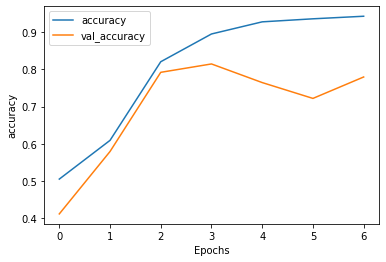

In [21]:
plot_graphs(history, "accuracy")

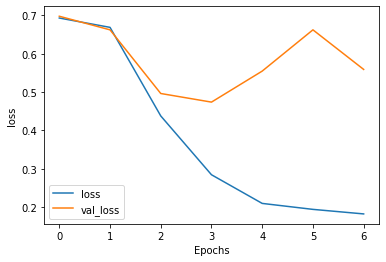

In [22]:
plot_graphs(history, "loss")

In [23]:
model_multiple_bidi_lstm.save('/content/sentiment_analysis.h5')

In [52]:
# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)